# Calculating the bitwise information content with Julia and Elefridge.jl
An example

## 0. TL;DR

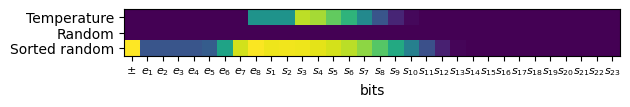

In [1]:
using NetCDF, PyPlot, Elefridge                                         # Load packages
ncfile = NetCDF.open("/data1/ens/ensemble.t.member1.steps1-90.ll.nc")   # Load ncfile
temp = ncfile.vars["t"][:,:,1,1]                                        # Retrieve one horizontal layer

bitinf_lon = bitinformation(temp)                                       # calculate bitinformation in longitude
bitinf_lat = bitinformation(permutedims(temp,[2,1]))                    # calculate bitinformation in latitude
bitinf_temp = (bitinf_lon + bitinf_lat)/2                               # Add & scale to 1

bitinf_rand = bitinformation(randn(Float32,100000))                     # Bitwise information for random N(0,1)
bitinf_sorted = bitinformation(sort(randn(Float32,100000)))             # Bitwise information for sorted random N(0,1)

imshow(hcat(bitinf_temp,bitinf_rand,bitinf_sorted)')                    # Plot for lon,lat,both
yticks(0:2,["Temperature","Random","Sorted random"])                    # label y ticks
xlabel("bits")                                                          # label x axis
xticks(0:31,vcat("±",[L"e_%$i" for i in 1:8],                           # label sign, exponent and significant bits
        [L"s_{%$i}" for i in 1:23]),fontsize=8);

# Now the long version:
## 1. Load / install required packages

In [2]:
# if not installed yet do using Pkg; Pkg.add("NetCDF"); Pkg.add("PyPlot") etc
# Elefridge is not yet registered,
# full github url is therefore required: Pkg.add("https://github.com/esowc/Elefridge.jl")
using NetCDF     
using PyPlot     
using Elefridge  

## 2. Retrieve data from a netcdf file

In [3]:
ncfile = NetCDF.open("/data1/ens/ensemble.t.member1.steps1-90.ll.nc")


##### NetCDF File #####

/data1/ens/ensemble.t.member1.steps1-90.ll.nc

##### Dimensions #####

Name                                                Length                    
--------------------------------------------------------------------------------
lat                                                 901                       
time                                                UNLIMITED (90 currently)  
lev                                                 11                        
nhyi                                                92                        
nhym                                                91                        
lon                                                 1800                      

##### Variables #####

Name                            Type            Dimensions                      
--------------------------------------------------------------------------------
lat                             DOUBLE          lat                             
hy

In [4]:
# load data for all longitudes, all latitudes, but only 1 vertical level and only the first time step
# into a Julia array
temp = ncfile.vars["t"][:,:,1,1]  

1800×901 Array{Float32,2}:
 270.099  271.781  272.033  272.048  …  233.155  233.483  233.263  233.109
 270.099  271.786  272.039  272.057     233.153  233.484  233.265  233.109
 270.099  271.79   272.045  272.066     233.152  233.485  233.268  233.109
 270.099  271.794  272.051  272.074     233.151  233.486  233.271  233.109
 270.099  271.799  272.057  272.083     233.149  233.488  233.273  233.109
 270.099  271.803  272.063  272.092  …  233.148  233.489  233.276  233.109
 270.099  271.807  272.07   272.101     233.147  233.49   233.278  233.109
 270.099  271.812  272.076  272.11      233.145  233.492  233.281  233.109
 270.099  271.816  272.082  272.118     233.144  233.493  233.283  233.109
 270.099  271.82   272.088  272.127     233.143  233.495  233.286  233.109
 270.099  271.825  272.094  272.136  …  233.142  233.496  233.289  233.109
 270.099  271.829  272.1    272.144     233.14   233.497  233.291  233.109
 270.099  271.833  272.106  272.153     233.139  233.499  233.294  233.10

## 3. Calculate bitwise information

For an array with `Float32,Float64` of any shape or size `bitinformation` from Elefridge calculates the bitwise information content. The array `temp` is lon x lat, and Julia is, like Fortran, column-major. Hence, the bitwise information will we calculated varying lon first (i.e. in zonal direction).

In [5]:
bitinf_lon = bitinformation(temp)

32-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.5247804655847595
 0.5247804655847595
 0.5247804655847595
 0.9150912167277832
 0.9003880872130032
 ⋮
 0.0009834086480837168
 0.0001785159038880657
 3.378799099607033e-5
 4.540478740544529e-6
 2.6755149382662324e-6
 1.1028484031561092e-6
 5.639345806218721e-6
 3.7861695600938106e-6
 1.6938705127422793e-7
 5.548234512708916e-6
 7.605972952184903e-6
 3.6178839610823132e-6

This returns a 32-element array, where each element is the information content of that bit (we started from Float32, hence 32 elements). We can calculate the information content in various dimensions by permuting them in the array

In [6]:
bitinf_lat = bitinformation(permutedims(temp,[2,1]))   # [2,1] means that the 2nd dimension comes first, etc.

32-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.4999272167162135
 0.49992721671621354
 0.49992721671621354
 0.8852801241406634
 0.8260100311236573
 ⋮
 3.1230878608790036e-6
 4.6010844305666154e-6
 6.1242314198795e-6
 1.762231115920443e-6
 2.4149280019036823e-6
 7.626932688742372e-7
 1.4998772643881608e-6
 2.4216865306403434e-6
 8.596781368996886e-7
 3.7257871003948395e-6
 7.324597640079311e-7
 2.8612963870466857e-6

If we are only interested in the total information content regardless of the dimension, we can add them

In [7]:
bitinf = (bitinf_lon + bitinf_lat)/2;

Here, the information content is also scaled. In that sense a bit that has 1 bit information has full information and is perfectly correlated (or anti-correlated) with the same bits in the surrounding grid points.

## 4. Plot the information

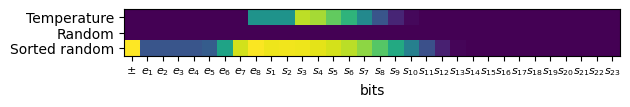

In [8]:
imshow(hcat(bitinf,bitinf_rand,bitinf_sorted)')                         # Plot for lon,lat,both
yticks(0:2,["Temperature","Random","Sorted random"])                    # label y ticks
xlabel("bits")                                                          # label x axis
xticks(0:31,vcat("±",[L"e_%$i" for i in 1:8],                           # label sign, exponent and significant bits
        [L"s_{%$i}" for i in 1:23]),fontsize=8);